In [23]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, validation_curve
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [5]:
processed_data_dir = Path("data/processed")
interim_data_dir = Path("data/interim")

df = pd.read_csv(interim_data_dir / "02_data.csv")
print("Full preprocessed dataframe:", df.shape)
print(df.head())

X_train = pd.read_csv(processed_data_dir / "X_train.csv")
X_val   = pd.read_csv(processed_data_dir / "X_val.csv")
X_test  = pd.read_csv(processed_data_dir / "X_test.csv")

y_train = pd.read_csv(processed_data_dir / "y_train.csv").squeeze("columns")
y_val   = pd.read_csv(processed_data_dir / "y_val.csv").squeeze("columns")
y_test  = pd.read_csv(processed_data_dir / "y_test.csv").squeeze("columns")

print("Train split:", X_train.shape, y_train.shape)
print("Validation split:", X_val.shape, y_val.shape)
print("Test split:", X_test.shape, y_test.shape)

Full preprocessed dataframe: (54170, 26)
              DateTime  Consumption  Production  Nuclear  Wind  Hydroelectric  \
0  2019-01-01 00:00:00         6352        6527     1395    79           1383   
1  2019-01-01 01:00:00         6116        5701     1393    96           1112   
2  2019-01-01 02:00:00         5873        5676     1393   142           1030   
3  2019-01-01 03:00:00         5682        5603     1397   191            972   
4  2019-01-01 04:00:00         5557        5454     1393   159            960   

   Oil and Gas  Coal  Solar  Biomass  ...  demand_High  hour day_of_week  \
0         1896  1744      0       30  ...        False     0           1   
1         1429  1641      0       30  ...        False     1           1   
2         1465  1616      0       30  ...        False     2           1   
3         1455  1558      0       30  ...        False     3           1   
4         1454  1458      0       30  ...        False     4           1   

   month  hour_

In [6]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
print(classification_report(y_val, y_pred, target_names=["Low","Medium","High"]))

              precision    recall  f1-score   support

         Low       0.82      0.75      0.78      3611
      Medium       0.61      0.58      0.59      3613
        High       0.72      0.81      0.76      3610

    accuracy                           0.71     10834
   macro avg       0.72      0.71      0.71     10834
weighted avg       0.72      0.71      0.71     10834



In [7]:
param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

xgb = XGBClassifier(random_state=42, n_jobs=-1)

grid_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    scoring="f1_macro",
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best macro F1:", grid_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsampl

In [8]:
param_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [1, 2, 3, 4, 5],
    "learning_rate": [0.06, 0.1, 0.14],
    "subsample": [0.6, 0.7, 0.8],
    "colsample_bytree": [0.6, 0.7, 0.8]
}

xgb = XGBClassifier(random_state=42, n_jobs=-1)

grid_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    scoring="f1_macro",
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best macro F1:", grid_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.14, max_depth=3, n_estimators=400, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.14, max_depth=3, n_estimators=400, subsample=0.7; total time=   1.2s
[CV] END colsampl

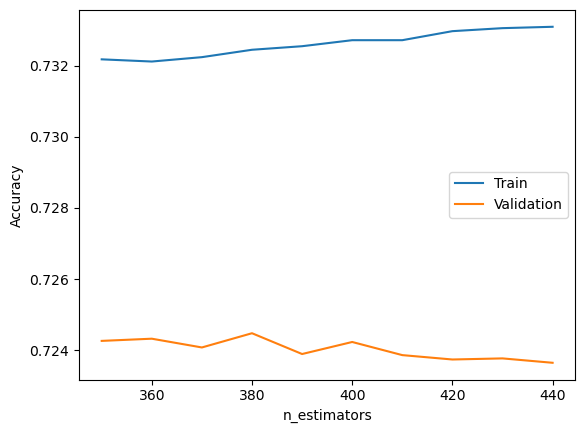

In [14]:
param_range = np.arange(350, 450, 10)

train_scores, val_scores = validation_curve(
    xgb,
    X_train, y_train,
    param_name='n_estimators',
    param_range=param_range,
    cv=5, scoring='accuracy'
)

plt.plot(param_range, train_scores.mean(axis=1), label='Train')
plt.plot(param_range, val_scores.mean(axis=1), label='Validation')
plt.xlabel('n_estimators'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

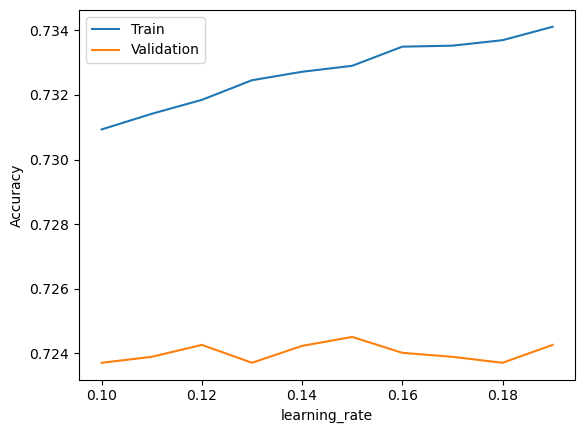

In [15]:
param_range = np.arange(0.1, 0.2, 0.01)

train_scores, val_scores = validation_curve(
    xgb,
    X_train, y_train,
    param_name='learning_rate',
    param_range=param_range,
    cv=5, scoring='accuracy'
)

plt.plot(param_range, train_scores.mean(axis=1), label='Train')
plt.plot(param_range, val_scores.mean(axis=1), label='Validation')
plt.xlabel('learning_rate'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

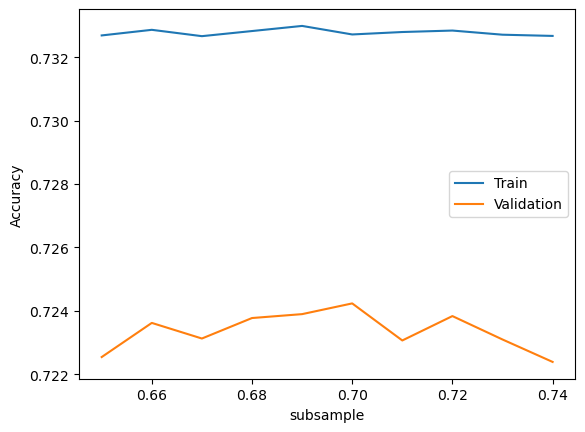

In [16]:
param_range = np.arange(0.65, 0.75, 0.01)

train_scores, val_scores = validation_curve(
    xgb,
    X_train, y_train,
    param_name='subsample',
    param_range=param_range,
    cv=5, scoring='accuracy'
)

plt.plot(param_range, train_scores.mean(axis=1), label='Train')
plt.plot(param_range, val_scores.mean(axis=1), label='Validation')
plt.xlabel('subsample'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

In [17]:
xgb = XGBClassifier(
    n_estimators=360,
    learning_rate=0.15,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
print(classification_report(y_val, y_pred, target_names=["Low","Medium","High"]))

              precision    recall  f1-score   support

         Low       0.82      0.76      0.79      3611
      Medium       0.62      0.58      0.60      3613
        High       0.72      0.83      0.77      3610

    accuracy                           0.72     10834
   macro avg       0.72      0.72      0.72     10834
weighted avg       0.72      0.72      0.72     10834



# Model Tuning & Comparison – SVM vs XGBoost

## XGBoost (Tuned)
- **Best Parameters:**  
  - `subsample`: 0.7  
  - `n_estimators`: 300–400  
  - `max_depth`: 3  
  - `learning_rate`: 0.10–0.14  
  - `colsample_bytree`: 0.7–0.8  
- **Performance:**  
  - Accuracy: ~0.72  
  - Macro F1: ~0.72  
  - Per-class:  
    - Low: Precision 0.82, Recall 0.75, F1 0.78–0.79  
    - Medium: Precision 0.62, Recall 0.58, F1 0.59–0.60  
    - High: Precision 0.72–0.73, Recall 0.81–0.83, F1 0.76–0.77  
- **Training speed:** Very fast (seconds per CV run).  
- **Strengths:** Matches SVM accuracy/F1 with dramatically faster runtime and better scalability.  

## Support Vector Machine (SVM)
- **Performance (previously tuned):**  
  - Accuracy: 0.72  
  - Macro F1: 0.72  
  - Per-class:  
    - Low: Precision 0.84, Recall 0.71, F1 0.77  
    - Medium: Precision 0.62, Recall 0.61, F1 0.61  
    - High: Precision 0.73, Recall 0.84, F1 0.78  
- **Training speed:** Much slower (minutes for CV).  
- **Strengths:** Slightly higher recall on High demand (0.84 vs 0.83).  
- **Weaknesses:** Computationally expensive for cross-validation and scaling.  

## Comparison
- Both models achieve **similar accuracy and macro F1 (~0.72)**.  
- **SVM** has a marginal edge in High demand recall, which could be critical in some business contexts.  
- **XGBoost** is far more efficient computationally and easier to scale to larger datasets or repeated retraining.  
- Both models still struggle with **Medium demand** classification.  

## Recommendation
- Prefer **XGBoost** for deployment: nearly identical predictive performance, much faster training, and scalable.  
- Retain **SVM** as a benchmark model when maximum High demand recall is a priority.  
- Next steps:  
  - Experiment with **LightGBM** or **CatBoost** for potential efficiency/accuracy trade-offs.  
  - Add **feature engineering (lag variables, holidays)** to improve Medium demand separation.  

In [24]:
voting_clf = VotingClassifier(
    estimators=[
        ("svm", SVC(probability=True, kernel="rbf", C=1, gamma=1, random_state=42)),
        ("rf", RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)),
        ("xgb", XGBClassifier(n_estimators=360, learning_rate=0.15, max_depth=3, subsample=0.7,
                              colsample_bytree=0.8, eval_metric="mlogloss", random_state=42)),
        ("knn", KNeighborsClassifier(n_neighbors=38))
    ],
    voting="soft"   # "hard" uses majority vote, "soft" averages probabilities
)

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Low","Medium","High"]))

Exception ignored in: <function ResourceTracker.__del__ at 0x1075dc040>
Traceback (most recent call last):
  File "/nix/store/pjd6lzr94flz4qg9ycpw09cc26zgfmyl-python3-3.13.5/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/nix/store/pjd6lzr94flz4qg9ycpw09cc26zgfmyl-python3-3.13.5/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/nix/store/pjd6lzr94flz4qg9ycpw09cc26zgfmyl-python3-3.13.5/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


              precision    recall  f1-score   support

         Low       0.82      0.73      0.78      3612
      Medium       0.62      0.60      0.61      3612
        High       0.73      0.83      0.78      3610

    accuracy                           0.72     10834
   macro avg       0.73      0.72      0.72     10834
weighted avg       0.73      0.72      0.72     10834



In [25]:
stacking_clf = StackingClassifier(
    estimators=[
        ("svm", SVC(probability=True, kernel="rbf", C=1, gamma=1, random_state=42)),
        ("rf", RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)),
        ("xgb", XGBClassifier(n_estimators=360, learning_rate=0.15, max_depth=3, subsample=0.7,
                              colsample_bytree=0.8, eval_metric="mlogloss", random_state=42)),
        ("knn", KNeighborsClassifier(n_neighbors=38))
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Low","Medium","High"]))

Exception ignored in: <function ResourceTracker.__del__ at 0x106564040>
Traceback (most recent call last):
  File "/nix/store/pjd6lzr94flz4qg9ycpw09cc26zgfmyl-python3-3.13.5/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/nix/store/pjd6lzr94flz4qg9ycpw09cc26zgfmyl-python3-3.13.5/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/nix/store/pjd6lzr94flz4qg9ycpw09cc26zgfmyl-python3-3.13.5/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


              precision    recall  f1-score   support

         Low       0.82      0.75      0.78      3612
      Medium       0.61      0.59      0.60      3612
        High       0.74      0.83      0.78      3610

    accuracy                           0.72     10834
   macro avg       0.72      0.72      0.72     10834
weighted avg       0.72      0.72      0.72     10834



Exception ignored in: <function ResourceTracker.__del__ at 0x109c64040>
Traceback (most recent call last):
  File "/nix/store/pjd6lzr94flz4qg9ycpw09cc26zgfmyl-python3-3.13.5/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/nix/store/pjd6lzr94flz4qg9ycpw09cc26zgfmyl-python3-3.13.5/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/nix/store/pjd6lzr94flz4qg9ycpw09cc26zgfmyl-python3-3.13.5/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104880040>
Traceback (most recent call last):
  File "/nix/store/pjd6lzr94flz4qg9ycpw09cc26zgfmyl-python3-3.13.5/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/nix/store/pjd6lzr94flz4qg9ycpw09cc26zgfmyl-python3-3.13.5/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/nix/store/pjd6lzr94flz4qg9

# Ensemble Model Evaluation – Voting vs Stacking

## XGBoost (Tuned Baseline)
- Accuracy: 0.72
- Macro F1: 0.72
- Strong performance on Low and High demand; Medium remains weakest (F1 ≈ 0.60).

## Voting Ensemble
- Accuracy: 0.72, Macro F1: 0.72
- Smooths predictions across SVM, RF, and XGB.
- Performance almost identical to XGBoost alone.
- Stability improved, but no significant gain.

## Stacking Ensemble
- Accuracy: 0.72, Macro F1: 0.72
- Meta-learner (Logistic Regression) learns weighted contributions.
- Per-class performance very similar to Voting.
- No major improvement because all base models share the same weakness on Medium demand.

---

## Reasoning
- **Voting**: Works well when models have complementary strengths. Here, all models agree strongly on Low and High demand, and all struggle with Medium, so averaging doesn’t add new information.
- **Stacking**: Can exploit disagreements among models, but since SVM, RF, and XGB already make very similar errors on Medium demand, the meta-learner cannot extract additional predictive signal.

---

## Conclusion
- **Optimal choice:** Tuned **XGBoost** alone – fastest training, simplest deployment, same performance as ensembles.
- **Voting/Stacking**: Useful for stability or redundancy, but not improving performance here.
- **Next step:** Focus on **feature engineering** (lags, external events, seasonality signals) to address Medium demand misclassification, since model ensembles have plateaued at ~0.72 Macro F1.